# Part 3: Machine learning

## Prediction of the prices for adults 

In [25]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix, mean_squared_error, r2_score 
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

We are going here to import the data that we have collected from de webscrapping done previously.

In [2]:
df=pd.read_excel("webscraping.xlsx")
df.head()

,Name,Type,City,Adults,Children,Latitude,Longitude
0,Abbaye de Maredsous et Le Saint-Joseph,Abbeys and religious monuments,Denée,0.0,0.0,47.378864,-0.607726
1,Abbaye d'Aulne,Abbeys and religious monuments,Gozée,5.0,1.0,50.333228,4.351559
2,Hôpital Notre-Dame à la Rose,Abbeys and religious monuments,Lessines,13.0,8.0,50.712304,3.830113
3,Musée de la Vie wallonne,Abbeys and religious monuments,Liège,7.0,5.0,50.645094,5.573611
4,Trésor de la Collégiale Ste-Waudru,Abbeys and religious monuments,Mons,4.0,2.0,50.454957,3.951958


In [3]:
print(df.dtypes)

Name          object
Type          object
City          object
Adults       float64
Children     float64
Latitude     float64
Longitude    float64
dtype: object


In order to do a regression, we should see if the prices of adults or children are correlated. If there are, we should include prices for children in the regression for the prices of adults and inversely.

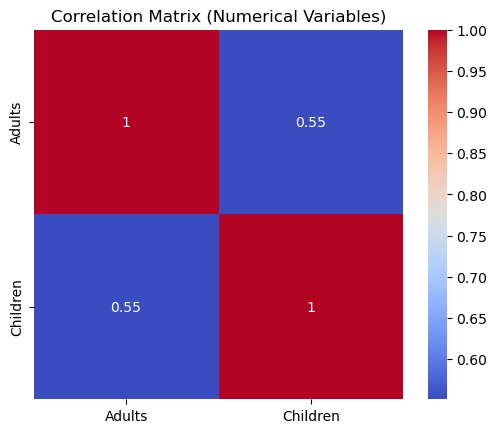

In [7]:
Num_cols = ['Adults', 'Children']
corr_matrix = df[Num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix (Numerical Variables)')
plt.show()

We see that there is a correlation of 0.55 between the prices of adults and children. This correlation of 0.55 suggests a moderate positive relationship between the two variables and we should therefore include this in the following regression.

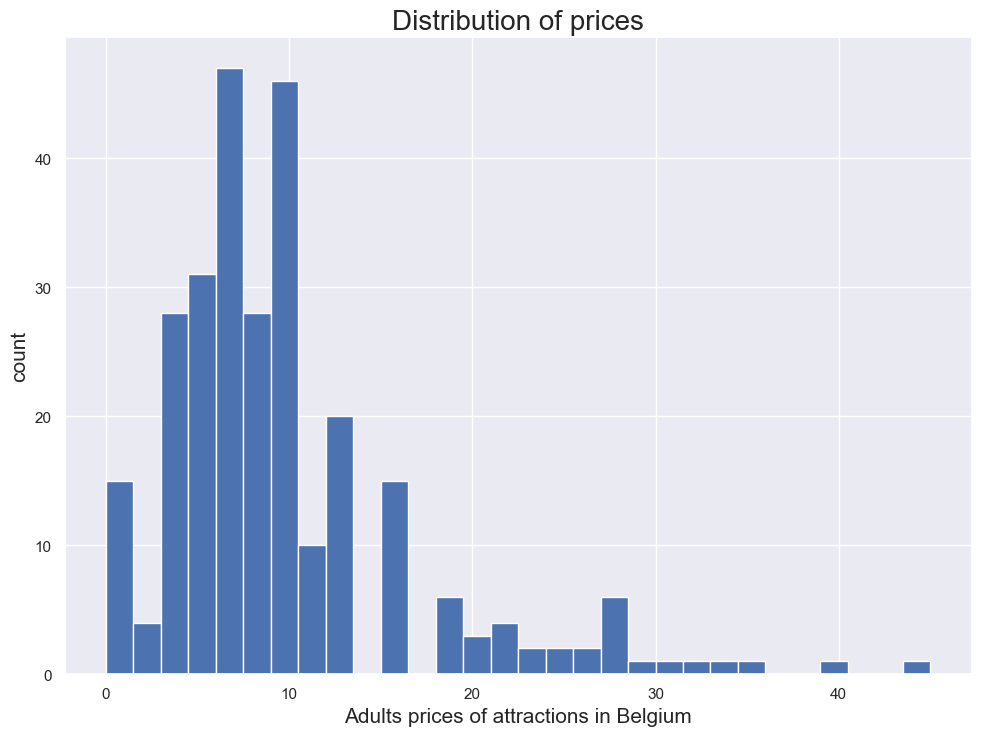

In [4]:
sns.set(rc={'figure.figsize':(11.7, 8.27)})
plt.hist(df['Adults'], bins=30)
plt.xlabel("Adults prices of attractions in Belgium", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of prices', size=20)
plt.show()

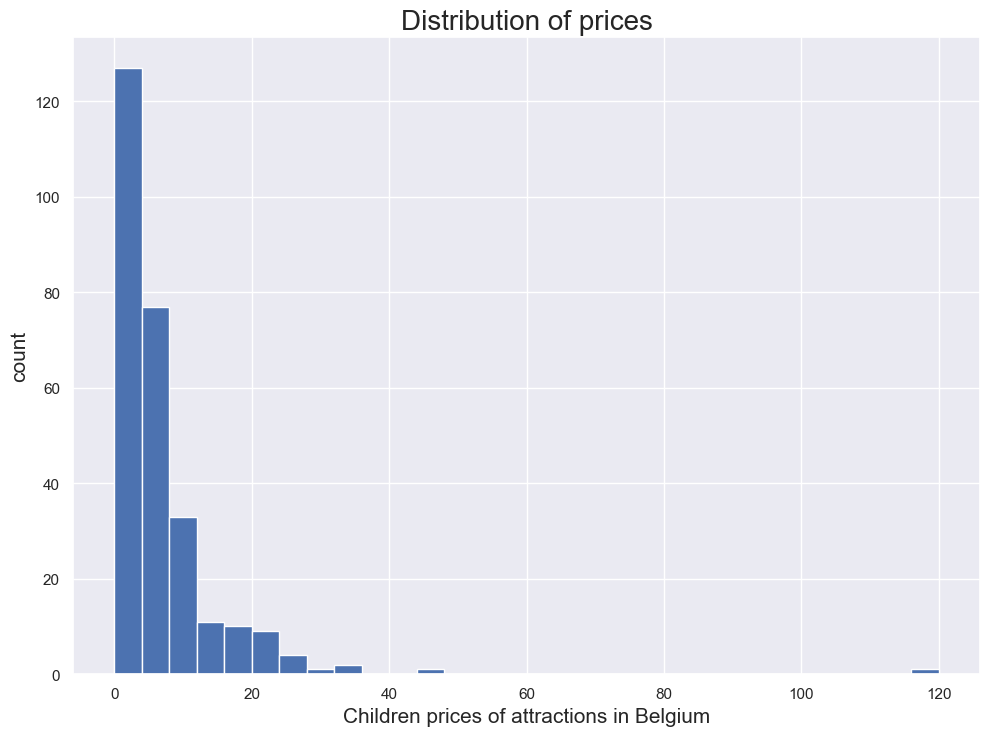

In [5]:
sns.set(rc={'figure.figsize':(11.7, 8.27)})
plt.hist(df['Children'], bins=30)
plt.xlabel("Children prices of attractions in Belgium", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of prices', size=20)
plt.show()

Let's thus define the  first variables of the first regression on the adults prices. We will here not include the variable of the prices of children. The prices of adults will here only depends on the city and the type of attractions.

In [90]:
X = df[['Type', 'City']]
y = df['Adults']

In [91]:
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), [0, 1])],
    remainder='passthrough'
)
X = ct.fit_transform(X)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [94]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [95]:
unique_types = df['Type'].unique()
unique_cities = df['City'].unique()
combinations = list(itertools.product(unique_types, unique_cities))
predict_df_adults = pd.DataFrame(combinations, columns=['Type', 'City'])
predict_data = ct.transform(predict_df_adults)
predicted_prices = model.predict(predict_data)
predict_df_adults['Predicted Adults Prices with model 1'] = predicted_prices

predict_df_adults1 = predict_df_adults[['City', 'Type', 'Predicted Adults Prices with model 1']]

print(predict_df_adults1)

               City                            Type  \
0             Denée  Abbeys and religious monuments   
1            Gozée   Abbeys and religious monuments   
2          Lessines  Abbeys and religious monuments   
3             Liège  Abbeys and religious monuments   
4              Mons  Abbeys and religious monuments   
...             ...                             ...   
2723  Vieux-Genappe                          UNESCO   
2724       Waterloo                          UNESCO   
2725           Coo                           UNESCO   
2726       Dochamps                          UNESCO   
2727     Houffalize                          UNESCO   

      Predicted Adults Prices with model 1  
0                                -0.026493  
1                                 5.000009  
2                                12.887541  
3                                 5.114064  
4                                 6.077846  
...                                    ...  
2723                    

We have then predicted the prices for the adults based on the city and the type of activity. But is this model a good fitting and does it gives good predictions ? We will then do some tests to assess, or not, of the results of the model.

In [96]:
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R-squared:", r2)

Train RMSE: 2.5273226910641196
Test RMSE: 6.561270274340995
R-squared: 0.47075772192075693


The R-squared value is a measure of how well the regression model fits the data. Here, the R-squared value of 0.47 indicates that approximately 47% of the variance in the dependent variable is explained by the independent variables. There is so a portion of the model which remains unexplained. Then, the RMSE measures the average prediction error of a regression model. Here, the train RMSE of 2.53 indicates that, on average, the predictions of the model on the training data are off by approximately 2.53 units. The test RMSE of 6.56 indicates that, on average, the predictions on the test data are off by approximately 6.56 units. A lower RMSE value indicates better predictive performance, so the train RMSE being lower than the test RMSE suggests that the model may be slightly overfitting the training data and not generalizing as well to the test data. Overall, the performance of the model seems to be moderate.

Here, we can predict one price for a precise type of activity and a precise city. This could be useful if we don't want to search in all the predictions.

In [97]:
new_data = [['Art', 'Bruxelles']]
new_data = ct.transform(new_data)
predicted_price = model.predict(new_data)
print("Predicted Price for Adults:", predicted_price)

Predicted Price for Adults: [9.77710087]


C:\Users\flori\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


We will then do a scatter plot of predicted price for adults versus actual price for adults. This can provide insights into the performance and accuracy of the regression model.

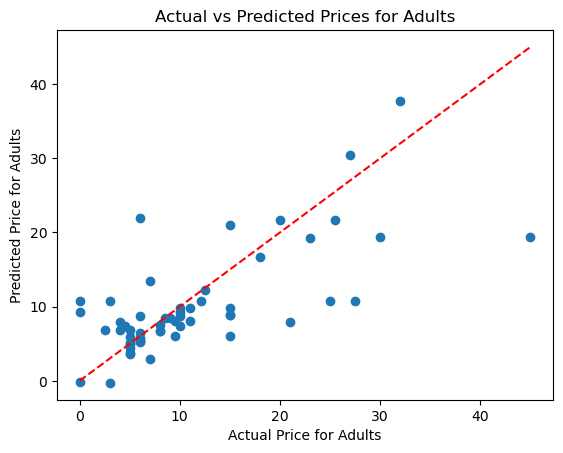

In [98]:
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Price for Adults')
plt.ylabel('Predicted Price for Adults')
plt.title('Actual vs Predicted Prices for Adults')
plt.show()

We can see that some points are closer to the diagonal line than other. The points close to this diagonal indicates that the model's predictions are close to the actual values. However, we also have points with a significant deviation from the diagonal line, it shows the error that we have with some prediction of the prices.

Let's now do the second regression. We will add here the prices of children in the regression in order to have more information in our model. We add the prices of children because we have seen that there is a moderate positive relationship between the two variables. Let's see the changes brought by this addition of variable in the model.

In [99]:
X = df[['Type', 'City', 'Children']]
y = df['Adults']

In [100]:
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), [0, 1])],
    remainder='passthrough'
)
X = ct.fit_transform(X)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [103]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [104]:
unique_types = df['Type'].unique()
unique_cities = df['City'].unique()
unique_children = df['Children'].unique()

combinations = list(itertools.product(unique_types, unique_cities, unique_children))
predict_df_adults = pd.DataFrame(combinations, columns=['Type', 'City', 'Children'])
predict_data = ct.transform(predict_df_adults)

predicted_prices = model.predict(predict_data)
predict_df_adults['Predicted Adults Prices with model 2'] = predicted_prices

predict_df_adults2f = predict_df_adults[['City', 'Type', 'Children', 'Predicted Adults Prices with model 2']]

print(predict_df_adults2)

                                  Type        City  Children  \
0       Abbeys and religious monuments       Denée      0.00   
1       Abbeys and religious monuments       Denée      1.00   
2       Abbeys and religious monuments       Denée      8.00   
3       Abbeys and religious monuments       Denée      5.00   
4       Abbeys and religious monuments       Denée      2.00   
...                                ...         ...       ...   
122755                          UNESCO  Houffalize     12.50   
122756                          UNESCO  Houffalize      9.75   
122757                          UNESCO  Houffalize      4.50   
122758                          UNESCO  Houffalize     14.50   
122759                          UNESCO  Houffalize     45.00   

        Predicted Adults Prices with model 2  
0                                   0.091672  
1                                   0.747306  
2                                   5.336747  
3                                   3.36984

In [105]:
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R-squared:", r2)

Train RMSE: 1.843819722037389
Test RMSE: 12.047322061724502
R-squared: -0.7842664757693221


From these test results, it appears that the model may be overfitting and not capturing the underlying patterns in the data accurately. We see that the model with only the city and the type of activities is a better fit than this one with the prices for children. Further analysis and model improvement may be necessary to address these issues and enhance the predictive performance of these two models. We will then make a test with a regression model based on the decision tree algorithm only with the city and the type of activity. 

In [109]:
X = df[['Type', 'City']]
y = df['Adults']

In [110]:
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), [0, 1])],
    remainder='passthrough'
)
X = ct.fit_transform(X)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [114]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [115]:
unique_types = df['Type'].unique()
unique_cities = df['City'].unique()
combinations = list(itertools.product(unique_types, unique_cities))
predict_df_adults = pd.DataFrame(combinations, columns=['Type', 'City'])
predict_data = ct.transform(predict_df_adults)
predicted_prices = model.predict(predict_data)
predict_df_adults['Predicted Adults Prices with model 2'] = predicted_prices

predict_df_adults2 = predict_df_adults[['City', 'Type', 'Predicted Adults Prices with model 2']]

print(predict_df_adults2)

               City                            Type  \
0             Denée  Abbeys and religious monuments   
1            Gozée   Abbeys and religious monuments   
2          Lessines  Abbeys and religious monuments   
3             Liège  Abbeys and religious monuments   
4              Mons  Abbeys and religious monuments   
...             ...                             ...   
2723  Vieux-Genappe                          UNESCO   
2724       Waterloo                          UNESCO   
2725           Coo                           UNESCO   
2726       Dochamps                          UNESCO   
2727     Houffalize                          UNESCO   

      Predicted Adults Prices with model 2  
0                                      0.0  
1                                      5.0  
2                                     13.0  
3                                      7.0  
4                                      4.0  
...                                    ...  
2723                    

In [116]:
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("R-squared:", r2)

Train RMSE: 1.8910317507252707
Test RMSE: 7.579362597914851
R-squared: 0.2937734455403861


The RMSE for the training set is 1.891, which indicates the average difference between the actual and predicted values of the target variable, as to know the prices for adults, is around 1.891. Lower values of RMSE suggest better model performance. The RMSE for the test set is 7.579, which is slightly higher than the train RMSE. This suggests that the model may be slightly less accurate when making predictions on unseen data. The R-squared is 0.294, indicating that the model explains approximately 29.4% of the variance in the Adults variable. This means that there is still a significant portion of the variance that remains unexplained.

In conclusion, we should use the linear regression with the type of attraction and the city. Indeed, the R-squared is bigger in this regression than the second one with the decision tree regression model. Moreover, the addition of the prices for children has made the model less performing. This could be cause by the uniqueness use in the prices of children. If we want to go further, we could use the first linear regression but we must add some information in the model in order to have a better fitting for the predictions.

In the following code , we will make an excel table with the predictions of the linear regression and the predictions of the decision tree regression model.

In [119]:
predict_df = predict_df_adults1.merge(predict_df_adults2, on=['Type', 'City'])
predict_df.sort_values(by='City', inplace=True)
print(predict_df)

                 City                                            Type  \
1709  Alle-sur-Semois  Industrial heritage and engineering structures   
97    Alle-sur-Semois                  Abbeys and religious monuments   
469   Alle-sur-Semois                                     Archaeology   
1089  Alle-sur-Semois                    Draisines and tourist trains   
717   Alle-sur-Semois                 Automotive and railway heritage   
...               ...                                             ...   
2640           Wéris                                           UNESCO   
1896           Wéris                                   Local products   
36             Wéris                   Abbeys and religious monuments   
2392           Wéris                        Theme and amusement parks   
1400           Wéris                         Handicrafts and know-how   

      Predicted Adults Prices with model 1  \
1709                              7.381474   
97                             

In [120]:
predict_df

,City,Type,Predicted Adults Prices with model 1,Predicted Adults Prices with model 2
1709,Alle-sur-Semois,Industrial heritage and engineering structures,7.381474,6.0
97,Alle-sur-Semois,Abbeys and religious monuments,6.035976,7.0
469,Alle-sur-Semois,Archaeology,6.092410,5.0
1089,Alle-sur-Semois,Draisines and tourist trains,12.418774,15.0
717,Alle-sur-Semois,Automotive and railway heritage,8.942047,6.0
...,...,...,...,...
2640,Wéris,UNESCO,4.695331,6.0
1896,Wéris,Local products,2.996635,6.5
36,Wéris,Abbeys and religious monuments,2.943604,7.0
2392,Wéris,Theme and amusement parks,16.271063,23.0


In [121]:
df2=predict_df

In [122]:
df2.to_excel('predict_df.xlsx', index=False)